In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon, pearsonr
from scipy.spatial.distance import jensenshannon
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
import networkx as nx

from utils.data import prepare_structural_methods, prepare_structural_healthy, match_structural_methods
from utils.paths import check_path

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:

def pcc(x, y, dim=-1):
    """
    Inputs:
        output: network output tensor of size (N, Features) N>1! 
        target: tensor of size (N, Features)
    Outputs:
        cc: correlation coefficient of each feature - tensor of size (Features,)
        mean_cc: mean correlation coefficient - scalar 
    """
    vx = x - torch.mean(x, dim=dim)
    vy = y - torch.mean(y, dim=dim)
    cc = torch.sum(vx * vy, dim=dim) / (torch.sqrt(torch.sum(vx ** 2, dim=dim)) * torch.sqrt(torch.sum(vy ** 2, dim=dim)))
    mean_cc = torch.mean(cc)
    std_cc = torch.std(cc)
    return cc, mean_cc, std_cc

def degree_distribution(G, rois, maximum_degree=1000, d_dg=1.):
    """
    Returns the probability distribution and the degrees in the graph. 
    Inputs:
        flattened: flattened graph
        rois: number of nodes
        maximum_degree: (int) maximum degree to which spans the probability
        d_dg: degree interval upon which the probability refers to (float)
    Outputs:
        prob: probability distribution of each degree in the network (numpy array)
        dgs: degrees present in the network until maximum_degree
    """
    degree_prob = np.zeros((int(maximum_degree//d_dg),))
    dgs = np.arange(0, maximum_degree+1)
    D_G = [jj for _,jj in G.degree(weight='weight')]
    #probs = (np.bincount([jj for _,jj in D_G])/rois)
    #dgs = np.unique([jj for _,jj in D_G])
    for d in range(maximum_degree):
        d_inf, d_sup = dgs[d], dgs[d+1]
        degree_prob[d] = np.sum((D_G>d_inf)*(D_G<d_sup))
    return degree_prob/rois, dgs

def KL_JS_divergences(G1, G2, rois, eps=1e-8):
    """ Computes the KL and JS Divergences between two degree distributions.
    Input:
        input: degree distribution of the input graph
        target: degree distribution of the target graph
        rois: number of nodes in the graph (to be used in the degree computation)
        eps: float to avoid log(0)
    Output:
        KL: divergence (torch scalar) 
        JS: divergence (torch scalar)
    """

    input_degree, _ = degree_distribution(G1, rois)
    target_degree, _ = degree_distribution(G2, rois)
    kl = np.sum(target_degree*np.log(target_degree+eps) - target_degree*np.log(input_degree+eps))
    js = jensenshannon(input_degree, target_degree)
    return kl, js

def raw_mat(x):
    return np.exp(x)-1

In [3]:
# Load data
normalize = False
CONTROL, C_subjects = prepare_structural_healthy(
'../Data/structural/graphs/hybrid/control', rois=170, sessions=['preop','postop'], norm=normalize, flatten=False, del_rois=[35,36,81,82], dtype=torch.float64
)
Hybrid_or, H_subjects = prepare_structural_methods(
'../Data/structural/graphs/hybrid/', rois=170, session='preop', norm=normalize, flatten=False, del_rois=[35,36,81,82], dtype=torch.float64
)
MSMT_or, MS_subjects = prepare_structural_methods(
'../Data/structural/graphs/msmt/', rois=170, session='preop', norm=normalize, flatten=False, del_rois=[35,36,81,82], dtype=torch.float64
)
Hybrid, MSMT, Patients = match_structural_methods(Hybrid_or, H_subjects, MSMT_or, MS_subjects)
NC, NH, NMS = CONTROL.shape[0], MSMT.shape[0], MSMT.shape[0]

metrics = ['Cosine-Similarity', 'Pearson-Correlation', 'Mean-Squared-Error']#, 'MSE-Clustering-Coeff', 'JS', 'MSE-Global-Eff', 'MSE-N_components']
N_metrics = len(metrics)

figures_path = check_path('RESULTS/figures/structural/')
numerical_path = check_path('RESULTS/numerical/structural/')

info = pd.read_csv('../Data/participants.tsv', sep='\t')
info = info[info["participant_id"].str.contains("CON") == False]
info.set_index(info.participant_id, inplace=True)
info.drop(['participant_id'], axis=1, inplace=True)
info.index.name = None
info["data_address"] = ""
for i,p in enumerate(Patients):
    info.loc[p, "data_address"]=i 
tumor_sizes = np.array([dict(info["tumor size (cub cm)"])[k] for k in Patients])
tumor_types = np.array([1 if 'ningioma' in dict(info["tumor type & grade"])[k] else 2 for k in Patients])
tumor_locs = np.array([1 if 'Frontal' in dict(info["tumor location"])[k] else 2 for k in Patients])
tumor_grade = np.array([2 if 'II' in dict(info["tumor type & grade"])[k] else 1 for k in Patients])
tumor_ventricles = np.array([2 if 'yes' in dict(info["ventricles"])[k] else 1 for k in Patients])

In [4]:
#!pip install powerlaw
import powerlaw

Values less than or equal to 0 in data. Throwing out 0 or negative values


Hybrid -- alpha:  4.199381083078578  Distance:  0.14513586825522484  sigma:  0.3968343834893857
MSMT -- alpha:  4.378192080237122  Distance:  0.17692126948931725  sigma:  0.44357835157090214


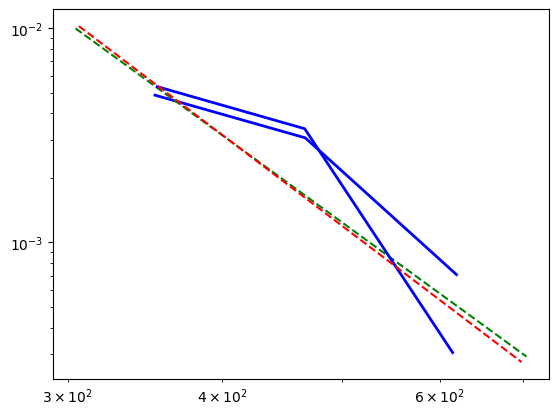

In [15]:
xmin = 300
id = info.loc["sub-PAT16","data_address"]
#G_MSMT = nx.from_numpy_array(raw_mat(MSMT[id]).numpy(force=True))
#G_MSMT = nx.from_numpy_array(raw_mat(MSMT[id]).numpy(force=True))
G_Hybrid = nx.from_numpy_array(Hybrid[id].numpy(force=True))
G_MSMT = nx.from_numpy_array(MSMT[id].numpy(force=True))

nodes_Hybrid, degrees_Hybrid = zip(*dict(G_Hybrid.degree(weight='weight')).items())
nodes_MSMT, degrees_MSMT = zip(*dict(G_MSMT.degree(weight='weight')).items())

degrees_MSMT_Hybrid = sorted([d for n, d in G_Hybrid.degree()], reverse=True)
degrees_MSMT_sorted = sorted([d for n, d in G_MSMT.degree()], reverse=True)

plt.figure(1)
fitH = powerlaw.Fit(degrees_Hybrid, discrete=True, estimate_discrete=True, xmin=xmin)#, xmin=10000, xmax=20000)
fig = fitH.plot_pdf(color='b', linewidth=2)
fitH.power_law.plot_pdf(color='g', linestyle='--', ax=fig)
fitM = powerlaw.Fit(degrees_MSMT, discrete=True, estimate_discrete=True, xmin=xmin)#, xmin=10000, xmax=20000)
fig = fitM.plot_pdf(color='b', linewidth=2)
fitM.power_law.plot_pdf(color='r', linestyle='--', ax=fig)

print("Hybrid -- alpha: ", fitH.power_law.alpha, " Distance: ", fitH.power_law.D, " sigma: ", fitH.power_law.sigma)
print("MSMT -- alpha: ", fitM.power_law.alpha, " Distance: ", fitM.power_law.D, " sigma: ", fitM.power_law.sigma)

In [16]:
fits_Hybrid, degrees_Hybrid, Graphs_Hybrid, alphas_Hybrid, Ds_Hybrid, sigmas_Hybrid = [], [], [], [], [], []
fits_MSMT, degrees_MSMT, Graphs_MSMT, alphas_MSMT, Ds_MSMT, sigmas_MSMT = [], [], [], [], [], []
for i,pat in enumerate(Patients):
    # Graphs
    G_Hybrid = nx.from_numpy_array(Hybrid[i].numpy(force=True))
    G_MSMT = nx.from_numpy_array(MSMT[i].numpy(force=True))
    # Degrees
    _, degrees_H = zip(*dict(G_Hybrid.degree(weight='weight')).items())
    _, degrees_M = zip(*dict(G_MSMT.degree(weight='weight')).items())
    # Power law fit
    fitH = powerlaw.Fit(degrees_H, discrete=True, estimate_discrete=True, xmin=xmin)
    fitM = powerlaw.Fit(degrees_M, discrete=True, estimate_discrete=True, xmin=xmin)
    # Record
    fits_Hybrid.append(fitH), degrees_Hybrid.append(degrees_H), Graphs_Hybrid.append(G_Hybrid)
    alphas_Hybrid.append(fitH.power_law.alpha), Ds_Hybrid.append(fitH.power_law.D), sigmas_Hybrid.append(fitH.power_law.sigma)
    fits_MSMT.append(fitM), degrees_MSMT.append(degrees_M), Graphs_MSMT.append(G_MSMT)
    alphas_MSMT.append(fitM.power_law.alpha), Ds_MSMT.append(fitM.power_law.D), sigmas_MSMT.append(fitM.power_law.sigma)

fits_Healthy, degrees_Healthy, Graphs_Healthy, alphas_Healthy, Ds_Healthy, sigmas_Healthy = [], [], [], [], [], []
for i,con in enumerate(C_subjects):
    # Graphs
    G_C = nx.from_numpy_array(CONTROL[i].numpy(force=True))
    # Degrees
    _, degrees_C = zip(*dict(G_C.degree(weight='weight')).items())
    # Power law fit
    fitC = powerlaw.Fit(degrees_C, discrete=True, estimate_discrete=True, xmin=xmin)
    # Record
    fits_Healthy.append(fitC), degrees_Healthy.append(degrees_C), Graphs_Healthy.append(G_C)
    alphas_Healthy.append(fitC.power_law.alpha), Ds_Healthy.append(fitC.power_law.D), sigmas_Healthy.append(fitC.power_law.sigma)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

In [17]:
print(F"HYBRID: Average distance= {np.array(Ds_Hybrid).mean()}, and average sigma= {np.array(sigmas_Hybrid).mean()}")
print(F"MSMT: Average distance= {np.array(Ds_MSMT).mean()}, and average sigma= {np.array(sigmas_MSMT).mean()}")
print(F"Healthy: Average distance= {np.array(Ds_Healthy).mean()}, and average sigma= {np.array(sigmas_Healthy).mean()}")

HYBRID: Average distance= 0.20082468600610479, and average sigma= 0.5781864993082275
MSMT: Average distance= 0.2248057406542884, and average sigma= 0.5983223417370559
Healthy: Average distance= 0.1575223218566766, and average sigma= 0.622482002504471


## Comapring against healthy

In [18]:
diff_alphas_hybridVShealthy = np.abs(np.array(alphas_Hybrid)-np.array(alphas_Healthy).mean())
diff_alphas_MSMTVShealthy = np.abs(np.array(alphas_MSMT)-np.array(alphas_Healthy).mean())

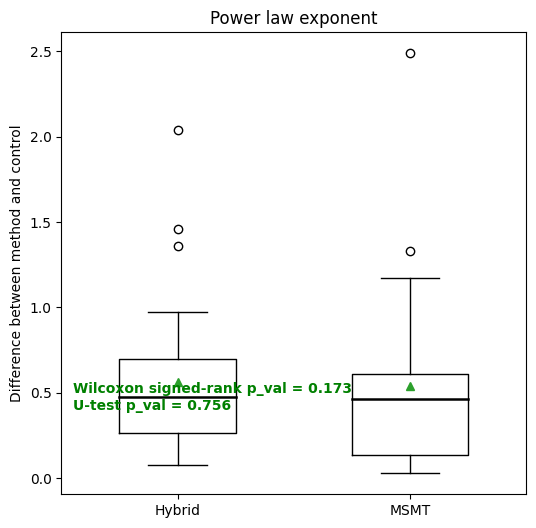

In [19]:
_, ax = plt.subplots(1,1,figsize=(6,6))
ax.boxplot([diff_alphas_hybridVShealthy, diff_alphas_MSMTVShealthy],
        positions=[1,2], widths=0.5, patch_artist=False,
        showmeans=True, showfliers=True,
        medianprops={'color':'black', 'linewidth':1.8},
        #meanprops={'marker':'s', 'markerfacecolor':'black', 'markeredgecolor':'black', 'markersize':6}
)
ax.set_xticklabels(["Hybrid", "MSMT"])
ax.set_ylabel("Difference between method and control")
ax.set_title("Power law exponent")
from scipy.stats import wilcoxon, mannwhitneyu
w,p = wilcoxon(diff_alphas_hybridVShealthy,diff_alphas_MSMTVShealthy)
wU,pU = mannwhitneyu(diff_alphas_hybridVShealthy,diff_alphas_MSMTVShealthy)
ax.text(0.55,0.5,f"Wilcoxon signed-rank p_val = {round(p,3)}", color="green", fontweight="bold")
ax.text(0.55,0.4,f"U-test p_val = {round(pU,3)}", color="green", fontweight="bold")
plt.savefig(f"./RESULTS/figures/structural/power_law_control_method_xmin-{xmin}.svg", dpi=500, format="svg")

## Comapring tractography pipelines methods

In [20]:
# SIMPLE LINEAR MODEL -- NO INTERACTION TERM
diff_alphas = np.array(alphas_MSMT)-np.array(alphas_Hybrid)
# Alphas
data_alphas = pd.DataFrame(
        {'delta_alphas': diff_alphas, 'size': tumor_sizes/np.max(tumor_sizes), 'type': tumor_types, 'grade': tumor_grade}
    )
model_alphas = ols(
    "delta_alphas ~ size + C(type) + C(grade)", data=data_alphas
).fit()
print(model_alphas.summary())

                            OLS Regression Results                            
Dep. Variable:           delta_alphas   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     4.438
Date:                Fri, 05 Jan 2024   Prob (F-statistic):             0.0145
Time:                        12:44:42   Log-Likelihood:                 9.9145
No. Observations:                  25   AIC:                            -11.83
Df Residuals:                      21   BIC:                            -6.954
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0251      0.055      0.454

In [21]:
# WITH INTERACTION TERM
diff_alphas = np.array(alphas_MSMT)-np.array(alphas_Hybrid)
# Alphas
model_alphas_int = ols(
    "delta_alphas ~ size + C(type) + C(grade) + size:C(type)", data=data_alphas
).fit()
print(sm.stats.anova_lm(model_alphas_int, typ=2))
print("===================================")
print(model_alphas_int.summary())

                sum_sq    df         F    PR(>F)
C(type)       0.101079   1.0  3.056503  0.095749
C(grade)      0.110536   1.0  3.342457  0.082470
size          0.307301   1.0  9.292374  0.006345
size:C(type)  0.000811   1.0  0.024533  0.877106
Residual      0.661405  20.0       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:           delta_alphas   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     3.180
Date:                Fri, 05 Jan 2024   Prob (F-statistic):             0.0356
Time:                        12:44:42   Log-Likelihood:                 9.9298
No. Observations:                  25   AIC:                            -9.860
Df Residuals:                      20   BIC:                            -3.765
Df Model:                           4                                     

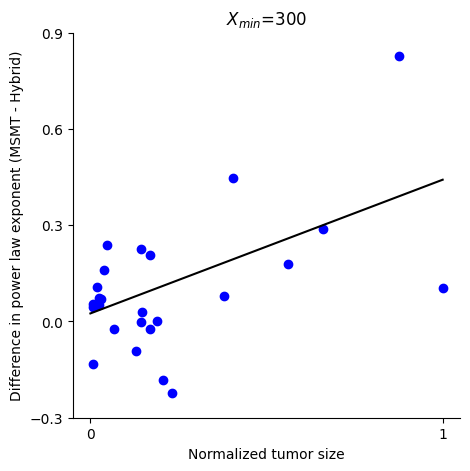

In [22]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(tumor_sizes/np.max(tumor_sizes),diff_alphas, c='blue')
ax.plot(np.linspace(0,1,400), model_alphas.params["size"]*np.linspace(0,1,400)+model_alphas.params["Intercept"],'black')
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
ax.set_xticks([0,1]), ax.set_xlabel("Normalized tumor size")
if xmin==300:
    ax.set_yticks([-0.3,0,0.3,0.6,0.9])
elif xmin==100:
    ax.set_yticks([-0.05,0,0.1])
else:
    ax.set_yticks([-0.1,0,0.1])
ax.set_ylabel("Difference in power law exponent (MSMT - Hybrid)")
ax.set_title("$X_{min}$"+f"={xmin}")
plt.savefig(f"./RESULTS/figures/structural/power_law_methods_xmin-{xmin}.svg", dpi=500, format="svg")

In [23]:
NC

11